# Project 2: Ames Housing Data

**Part 3 Modelling**

**1. Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
# importing engineered Data
df_train = pd.read_csv('D:/GA/DSI3lab/dsi3test/project_2/datasets/train_dummies.csv')

#Set id as index 
df_train.set_index('id', inplace=True)

# Check for nulls
(df_train.isnull().sum())[df_train.isnull().sum() > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [3]:
df_train.shape

(2043, 512)

**2. Features and targeting vector**

In [4]:
features = [col for col in df_train._get_numeric_data().columns if col != 'saleprice']
X = df_train[features]
y = df_train['saleprice']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
#scaling 
ss =StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

In [7]:
#Instantiate Models
lr = LinearRegression()
lasso = LassoCV(n_alphas = 200)
ridge = RidgeCV(alphas = np.linspace(.1, 10, 100))

**3.Cross-val all model**

In [8]:
# Linear Regression
lr_scores = cross_val_score(lr, X_train_ss, y_train, cv=5)
lr_scores.mean()

-2.425306489215784e+24

In [9]:
# Ridge
# Find optimal value for ridge regression alpha
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train_ss, y_train)

print (optimal_ridge.alpha_)

36.12342699709432


In [10]:
# Cross-validate the Ridge regression with the optimal alpha.
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X_train_ss, y_train, cv=5)
ridge_scores.mean()

0.9366250145737804

In [11]:
# Lasso
# Find optimal value for lasso regression alpha
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train_ss, y_train)

print (optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

391.11987398410054


..........[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.4s finished


In [12]:
# Lasso
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_train_ss, y_train, cv=5)
lasso_scores.mean()

0.9499303053806454

The mean R^2 of Linear Regression model is extremely negative which might be an indication of overfitting where there are a large number of redundant variables that are affecting the coefficients in a certain ways.

However as Ridge is able to manage multicollinearity, the mean R^2 improves drastically

The Lasso here performs only slightly better than the Ridge but that is because it is pretty similar to Ridge. But on top of that it does feature selection which of valuable variables, which also eliminate those that are not useful.

In [13]:
# Refit outside cross_val_score
lasso.fit(X_train_ss, y_train)

# coefficients for variables in the Lasso
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
33,log_saleprice,56671.786988,56671.786988
34,total_sf,9388.619304,9388.619304
220,neighborhood_NridgHt,6275.273472,6275.273472
6,bsmtfin_sf_1,4102.431269,4102.431269
226,neighborhood_StoneBr,3990.719753,3990.719753
5,mas_vnr_area,3315.553695,3315.553695
48,ms_subclass_120,-3275.064833,3275.064833
337,year_built_2008,2975.613400,2975.613400
38,ms_subclass_30,2884.453511,2884.453511
18,bedroom_abvgr,-2754.208506,2754.208506


In [14]:
print ('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(X.shape[0]))

Percent variables zeroed out: 0.17180616740088106


In [15]:
lasso_coefs.to_csv('D:/GA/DSI3lab/dsi3test/project_2/datasets/lasso_coefs.csv')

**Inferential Visualizations**

**1. Model Fitting and Evaluate**

In [16]:
lasso.fit(X_train_ss, y_train)
lasso.score(X_train_ss, y_train)

0.9657520880463718

In [17]:
lasso.score(X_test_ss, y_test)

0.9482736241646486

In [18]:
#Predict target values
pred = lasso.predict(X_test_ss)
r2_score(y_test, pred)

0.9482736241646486

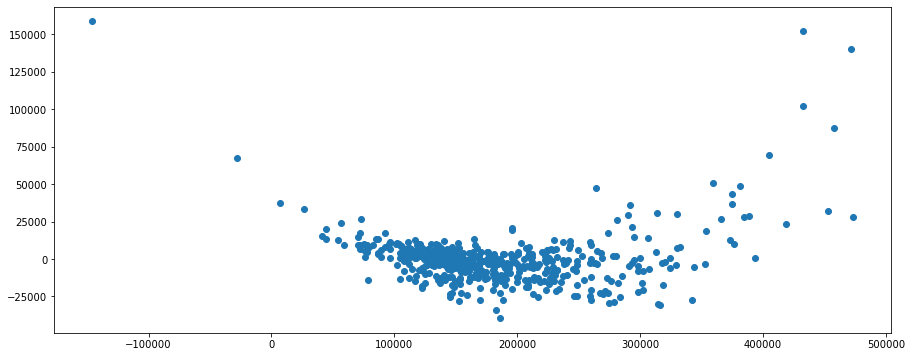

In [19]:
#Plot of the Errors
residuals = y_test - pred

plt.figure(figsize=(15,6))
plt.scatter(pred, residuals);

**2. Ridge and Lasso Comparison**

In [20]:
ridge.fit(X_train_ss, y_train)
ridge.score(X_train_ss, y_train)

0.9720784972483679

In [21]:
ridge.score(X_test_ss, y_test)

0.9422198633506109

In [22]:
pred_r = ridge.predict(X_test_ss)
r2_score(y_test, pred_r)

0.9422198633506109

**3.Import data(test) from EDA_test**

In [23]:
df_test = pd.read_csv("./datasets/test_final.csv")
df_test.shape

(878, 485)

In [24]:
# #compare against train df
df_train.shape

(2043, 512)

Further exploration is required. Feature number dont tally 

**4. Missing columns**

In [25]:
# As only certain columns are used to run the models, 
# we will be looking at the features instead
features = [col for col in df_train._get_numeric_data().columns if col != 'saleprice']

missing_features = [col for col in features if ~np.isin(col,df_test.columns)]
missing_features

['pid',
 'log_saleprice',
 'ms_subclass_150',
 'ms_zoning_C (all)',
 'street_Pave',
 'utilities_NoSeWa',
 'condition_2_Feedr',
 'condition_2_PosN',
 'condition_2_RRAe',
 'condition_2_RRAn',
 'condition_2_RRNn',
 'roof_matl_Membran',
 'exterior_1st_CBlock',
 'exterior_1st_ImStucc',
 'exterior_1st_Stone',
 'exterior_2nd_Stone',
 'heating_OthW',
 'heating_Wall',
 'central_air_Y',
 'electrical_Mix',
 'functional_Sal',
 'functional_Sev',
 'misc_feature_TenC',
 'neighborhood_GrnHill',
 'neighborhood_Landmrk',
 'year_built_1875',
 'year_built_1879',
 'year_built_1880',
 'year_built_1893',
 'year_built_1895',
 'year_built_1896',
 'year_built_1898',
 'year_built_1901',
 'year_built_1911',
 'year_built_1913',
 'year_built_1929',
 'year_built_1942',
 'garage_yr_blt_1896.0',
 'garage_yr_blt_1900.0',
 'garage_yr_blt_1914.0',
 'garage_yr_blt_1919.0',
 'garage_yr_blt_1929.0',
 'garage_yr_blt_1933.0',
 'garage_yr_blt_1936.0',
 'garage_yr_blt_1942.0',
 'garage_yr_blt_1945.0',
 'garage_yr_blt_2207.0']

In [26]:
df_test = pd.concat([df_test, pd.DataFrame(columns = missing_features)]).fillna(0)
df_test[features].shape

(878, 500)

In [27]:
#Check for null values
(df_test.isnull().sum())[df_test.isnull().sum() > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [28]:
# Check for any duplicates
df_test.duplicated().sum()

0

In [29]:
#features = [col for col in df_test._get_numeric_data().columns if col != 'saleprice']
prediction = df_test[features]
X_testdf_ss = ss.transform(df_test[features])
df_test['saleprice'] = lasso.predict(X_testdf_ss)
df_test['id'] = df_test['id'].astype(int)
kaggle_submission = df_test[['id','saleprice']].set_index('id')

In [30]:
kaggle_submission.to_csv('./datasets/kaggle_submission.csv')